# Tangramm - predictive modelling using train and test samples

The input adata contains:
    42 units of training set
    941 units of testing set
    259 features in any of population units
    all of the data are supposed to be continuous values.
    
The plan of investigation:
1. Data scaling (standatization of features)
2. Filter the features - reduce the number of features to use in model fitting
3. Select the models that can be used  for prediction
4. Fitting the models with different parameters
5. Choose the best model

##### Data scaling (standatization of features)
Scale the features to transform the original sample to sample with Mean==0, and Standard deviation==1

##### Filter the features
Try to reduce the number of features and use the most significant for modelling using the mutual information assessment between features and output predicted values.

##### Aggregate the  features
Group the features that are correlated and contain mutual information.

##### Select the models that can be used  for prediction
There are three different regression models that were choosen to predict the output:
Kernel Ridge Regression
Random Forest Regression
Support Vector Regression
Any of them can predict the continuous output that is necessary according to the problem statement.

##### Fitting the models with different parameters
Kernel Ridge Regression and Support Vector Regression can have different kernels - linear or nonlinear and other paramenters that can be used for fitting.
Random Forest Regression is the mix of decision trees that is used to achieve best model on the training set.

##### Choose the best model
Using the assessment of different models with different parameters we chose the best one based on train data. The prediction is built for test data. Then we calculate the assessment of achieved results using mean squarerd error(MSE), mean relative error(MRE) and analysis of error's distribution.

##### Import required libraries

In [3]:

from sklearn.datasets import load_boston
from sklearn.linear_model import (LinearRegression, Ridge, 
                                  Lasso, RandomizedLasso)
from sklearn import svm        
from sklearn.grid_search import GridSearchCV                          
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import RFE, f_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd


##### Data scaling (standatization of features)

In [4]:
#Import data
D=pd.read_csv("https://raw.githubusercontent.com/AnnaDS/tangramm/master/tangramm_test.csv")
D.columns=[x.strip() for x in D.columns]
Dtrain=D[D['test']==0]
Dtest=D[D['test']==1]
r=list(D.columns.difference(['test', 'class']))
#Data frame of train samples
Dtrain_x=Dtrain[r]
#Data frame of test samples
Dtest_x=Dtest[r]

#Use standartization to scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(Dtrain_x)
y_train=Dtrain['class']

X_test = scaler.fit_transform(Dtest_x)
y_test =Dtest['class']
names=Dtest_x.columns


##### Filter the features
We'll try to eliminate the noise features that brings only the uncertainty to modelling. The idea is to apply different models and define those features that correspond to 0 coefficients (get this coefficient while training).
These models are:
LinearRegression - Least squares Linear Regression. It provide the information about the linear correlation itself.
Ridge - Linear least squares goal function with l2 regularization (forces regressions coefficients to spread out similarly between correlated variables).
Lasso - Linear Model trained with L1 prior as regularizer. It picks out the top performing features, while forcing other features to be close to zero.
RandomizedLasso - The model is used to select the most stable features.
RFE - Randomized feature elimination. At first all sample of features is analysed and ranked then one with the lowest rank is eliminayed and we reduce the number of features. This process repeated while the number of features is reduced enough (according to the parameters).
RandomForest - The mix and sample of decision trees that are applied. Random forest’s impurity based ranking is typically aggressive in the sense that there is a sharp drop-off of scores after the first few top ones. 

Using all these models the mean rank for all features is calculated and we use those that correspond to the higher mean rank according to the filter_limit


In [5]:
def rank_to_dict(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x, 2), ranks)
    return dict(zip(names, ranks ))

filter_limit=0.1

ranks = {}
lr = LinearRegression(normalize=True)
lr.fit(X_train, y_train)
ranks["Linear reg"] = rank_to_dict(np.abs(lr.coef_), names)
 
ridge = Ridge()
ridge.fit(X_train, y_train)
ranks["Ridge"] = rank_to_dict(np.abs(ridge.coef_), names)
 
 
lasso = Lasso(alpha=.01)
lasso.fit(X_train, y_train)
ranks["Lasso"] = rank_to_dict(np.abs(lasso.coef_), names)
 
 
rlasso = RandomizedLasso(alpha=0.01)
rlasso.fit(X_train, y_train)
ranks["Stability"] = rank_to_dict(np.abs(rlasso.scores_), names)
 
#stop the search when 5 features are left (they will get equal scores)
rfe = RFE(lr, n_features_to_select=5)
rfe.fit(X_train,y_train)
ranks["RFE"] = rank_to_dict(list(map(float, rfe.ranking_)), names, order=-1)
 
rf = RandomForestRegressor()
rf.fit(X_train,y_train)
ranks["RF"] = rank_to_dict(rf.feature_importances_, names)
 
 
f, pval  = f_regression(X_train, y_train, center=True)
ranks["Corr."] = rank_to_dict(np.nan_to_num(f), names)

dd=pd.DataFrame(ranks) 
dd['avg_importance']=dd.apply(np.mean, 1)
dd=dd.sort("avg_importance")

dd_tr=dd[dd["avg_importance"]>filter_limit]
ind=dd_tr.index
Dtrain_x1=Dtrain_x[ind]
Dtest_x1=Dtest_x[ind]

scaler = StandardScaler()
X01 = scaler.fit_transform(Dtrain_x1)
X02 = scaler.fit_transform(Dtest_x1)

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:43: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [6]:
# The most unsignificant features according to the avg_importance
print(dd.head(10))

      Corr.  Lasso  Linear reg  RF   RFE  Ridge  Stability  avg_importance
x156      0   0.00        0.00   0  0.00   0.00       0.00        0.000000
x157      0   0.00        0.00   0  0.00   0.00       0.00        0.000000
x60       0   0.00        0.00   0  0.01   0.00       0.00        0.001429
x155      0   0.00        0.00   0  0.01   0.00       0.00        0.001429
x158      0   0.00        0.00   0  0.02   0.00       0.00        0.002857
x61       0   0.00        0.00   0  0.02   0.00       0.00        0.002857
x55       0   0.00        0.00   0  0.07   0.00       0.00        0.010000
x47       0   0.01        0.00   0  0.07   0.00       0.00        0.011429
x248      0   0.02        0.01   0  0.03   0.01       0.02        0.012857
x64       0   0.02        0.00   0  0.09   0.00       0.01        0.017143


In [5]:
# The most significant features according to the avg_importance
print(dd.tail(10))

      Corr.  Lasso  Linear reg    RF   RFE  Ridge  Stability  avg_importance
x232   0.06   0.04        0.38  0.00  1.00   0.38       0.71        0.367143
x101   0.02   0.51        0.35  0.09  0.89   0.34       0.38        0.368571
x163   0.03   0.19        0.43  0.07  0.85   0.41       0.73        0.387143
x128   0.15   0.56        0.22  0.10  0.98   0.22       0.52        0.392857
x12    0.12   1.00        0.23  0.12  0.86   0.23       0.20        0.394286
x190   0.12   0.37        0.48  0.42  0.93   0.48       0.22        0.431429
x144   0.12   0.38        0.44  0.02  0.92   0.44       0.71        0.432857
x89    0.17   0.11        0.44  0.00  0.96   0.44       0.97        0.441429
x191   0.23   0.40        0.64  0.00  0.83   0.63       0.62        0.478571
x192   1.00   0.88        1.00  0.00  0.98   1.00       1.00        0.837143


The number of features was reduced from 249 to 152 using this filtration

Selected significant features
['x184', 'x170', 'x76', 'x53', 'x21', 'x241', 'x88', 'x1', 'x180', 'x188', 'x107', 'x82', 'x234', 'x238', 'x63', 'x85', 'x16', 'x11', 'x145', 'x51', 'x122', 'x247', 'x113', 'x41', 'x37', 'x211', 'x14', 'x141', 'x200', 'x2', 'x15', 'x129', 'x6', 'x59', 'x204', 'x120', 'x206', 'x75', 'x5', 'x123', 'x4', 'x162', 'x203', 'x143', 'x97', 'x240', 'x25', 'x0', 'x186', 'x29', 'x42', 'x239', 'x148', 'x189', 'x245', 'x48', 'x80', 'x87', 'x127', 'x84', 'x124', 'x139', 'x45', 'x71', 'x92', 'x77', 'x208', 'x125', 'x105', 'x78', 'x79', 'x147', 'x225', 'x38', 'x95', 'x242', 'x35', 'x210', 'x43', 'x205', 'x224', 'x106', 'x22', 'x24', 'x8', 'x91', 'x57', 'x115', 'x20', 'x30', 'x100', 'x230', 'x138', 'x193', 'x10', 'x112', 'x201', 'x23', 'x70', 'x236', 'x130', 'x83', 'x202', 'x118', 'x13', 'x28', 'x81', 'x72', 'x58', 'x68', 'x244', 'x227', 'x3', 'x102', 'x104', 'x110', 'x150', 'x86', 'x154', 'x62', 'x103', 'x18', 'x197', 'x96', 'x26', 'x195', 'x44', 'x109', 'x40', 'x32', 'x1

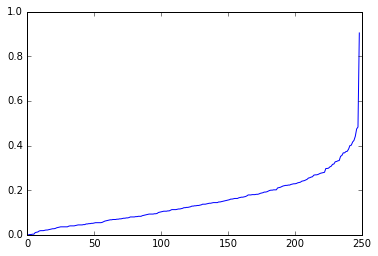

In [7]:
# Plot of fetures significance using proposed approach
x=range(dd.shape[0])
plt.plot(x, list(dd.avg_importance))
print("Selected significant features")
print(list(Dtrain_x1.columns))

##### Aggregate the  features
The main difficulty of this step is find out how many groups of features we can get and what grouping method should be applied. I've chosed agglomerative clustering for data grouping when the features are grouped from step to step (the type of hierarchial clustering). It implemented with the FeatureAgglomeration methon python(sklearn).
The number of groups that should be build after clusterization was resumably defined with Silhouette approach https://en.wikipedia.org/wiki/Silhouette_(clustering). Of course thare are no papers (I have'nt found any) that provide the combination of Silhouette approach and Agglomerative clustering using together for clustering, but I haven't found any obstacles not to do this.

In [8]:
from sklearn.cluster import FeatureAgglomeration
from sklearn import metrics

def get_numb_clust(X):
    cl_assess=pd.DataFrame()
    range_n_clusters = range(2, round(X.shape[1]/2))
    X1=np.rot90(X)    
    for n_clusters in range_n_clusters:
        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X1)
    
        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X1, cluster_labels)
        #print("For n_clusters =", n_clusters,
        #      "The average silhouette_score is :", silhouette_avg)
        cl_assess=cl_assess.append(pd.DataFrame([[n_clusters,silhouette_avg]], columns=['n_clusters', 'assessment']))   
    cl_assess['rounded']=([round(x,1) for x in cl_assess.assessment])    
    return list(cl_assess.n_clusters[cl_assess.rounded==max(cl_assess.rounded)])[0] 

cluster_number=get_numb_clust(X01)
print("Defined number of feature clusters ", cluster_number)
fa=FeatureAgglomeration(n_clusters=cluster_number)
fa.fit(X01)


labels_=fa.labels_

#get the test set of features
X_train_new=fa.transform(X01)
X_test_new=np.zeros(shape=( len(y_test),cluster_number))

for i in set(labels_):
    #print(i)
    cl0=np.where(fa.labels_==i)
    cl01=[cl0[0][i] for i in range(len(cl0[0]))]
    X_test_agl=X02[:, cl01]
    X_test_new[:,i]=X_test_agl.mean(axis=1)


Defined number of feature clusters  70


The number of train data is too low (only 42 units vs 951 units for testing), so it hard to avoid the underfitting. Overfitting should be also avoided. In fact the output fits to lognormal distribution with:
count       42.000000
mean     16359.889762
std       7732.258050
min       8563.510000
25%      11900.375000
50%      14095.650000
75%      17046.825000
max      47700.40000

Additional statistics
skewness=3.543
kurtosis=19.3358

The picture of sample distribution is provided below. It is shown than the output bata can be even not contnuous because of the histogram gaps.
Thust there is an uncertainty in population and big number of features that makes any model of prediction not accurate enough.

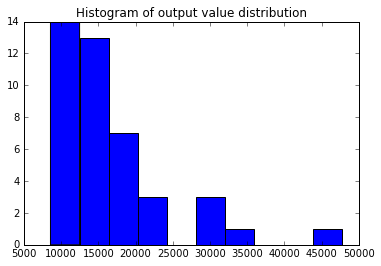

In [119]:
plt.hist(y_train)
plt.title("Histogram of output value distribution")

##### Select the models that can be used  for prediction
##### Fitting the models with different parameters
At this poin the 259 features are transformed to 70 groups that describe these features and the average values of groups will be used for modelling. In fact we are still faced with the curse of dimensionality but after grouping the multicollinearity decreased. The number of population units is very small, the distribution of outcome doesn't fit the normal distribution so in any case the prediction contains a lot of uncertainty and the level of ucertainty even cannot be defined, e. x. 0.9, 0.75, 0.5...
Thus choosing the model for prediction we should pay attention to interval prediction with corresponded confidence intervals. The Quantile Regression Forests model is chosen (http://www.jmlr.org/papers/volume7/meinshausen06a/meinshausen06a.pdf) to find such predictions.
The idea of the method is not to chose the average value of every leave of tree but take all sample of responses into accont. Using these samples the quantiles of 5%, 95% can be calculated. So the confidence inteval of prediction  will contain the "analysis of predicted samples" for each value and calculated quantiles.

The model fitiing for the trained data with the confidence interval calculation is provided below.

Fitting 3 folds for each of 42 candidates, totalling 126 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    8.1s
[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:   27.8s finished


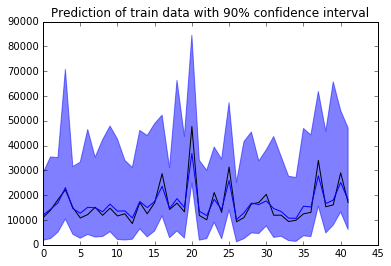

In [37]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
from sklearn.ensemble import RandomForestRegressor

def pred_ints(model, X, percentile=95):
    err_down = []
    err_up = []
    for x in range(len(X)):
        preds = []
        for pred in model.estimators_:
            preds.append(pred.predict(X[x])[0])
        err_down.append(np.percentile(preds, (100 - percentile) / 2. ))
        err_up.append(np.percentile(preds, 100 - (100 - percentile) / 2.))
    return err_down, err_up

best=pd.DataFrame()

#Random Forest regression
rf=RandomForestRegressor()
parameters_rf = {'n_estimators': [500,700], 'max_depth': [None, 1, 2, 3, 4, 5,6], 'min_samples_split': [1, 2, 3]}
gs_rf = GridSearchCV(rf,parameters_rf,n_jobs=8,verbose=1)
gs_rf.fit(X_train_new, y_train)
best=best.append(pd.Series({'model':'RandomForest', 'estimator':gs_rf.best_estimator_, 'score': gs_rf.best_score_, 'params':gs_rf.best_params_}), ignore_index=True)


V=best.score.tolist().index(max(best.score))
BV=best.ix[[V]]
rf = BV.estimator.tolist()[0]

rf.fit(X_train_new, y_train)
err_down, err_up = pred_ints(rf, X_train_new, percentile=90)
#plt.plot(list(y_train))
#plt.plot(rf.predict(X_train_new))
#plt.plot([a+b for a,b in zip(list(rf.predict(X_train_new)),list(err_up))])
#plt.plot([a-b for a,b in zip(list(rf.predict(X_train_new)),list(err_down))])

DT=D[D['test']==0]['class']
DT=pd.DataFrame(DT)
DT['pred']=list(rf.predict(X_train_new))
DT['down_conf']=[a-b for a,b in zip(list(rf.predict(X_train_new)),list(err_down))]
DT['upper_conf']=[a+b for a,b in zip(list(rf.predict(X_train_new)),list(err_up))]
plt.figure()
plt.plot(DT.index, DT['class'], 'k', label='Real train')
plt.plot(DT.index, DT['pred'], 'b')
plt.fill_between(DT.index,DT['down_conf'], DT['upper_conf'], color='b', alpha=0.5)
plt.title("Prediction of train data with 90% confidence interval")

In [38]:
rf

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=700, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

Now the model is applied to the test data. And the results are provided below.

Ration of values in 90% confidence interval
0.8352816153028693  % of predicted values


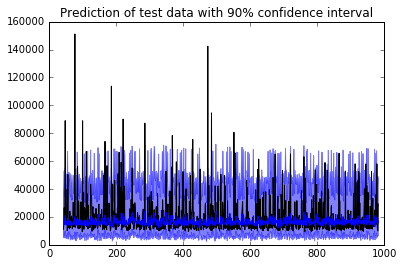

In [39]:
err_down, err_up = pred_ints(rf, X_test_new, percentile=90)

correct = 0.
for i, val in enumerate(list(y_test)):
    if err_down[i] <= val <= err_up[i]:
        correct += 1
print ("Ration of values in 90% confidence interval")        
print (correct/len(list(y_test)), " % of predicted values")

DC=D[D['test']==1]['class']
DC=pd.DataFrame(DC)
DC['pred']=list(rf.predict(X_test_new))
DC['down_conf']=[a-b for a,b in zip(list(rf.predict(X_test_new)),list(err_down))]
DC['upper_conf']=[a+b for a,b in zip(list(rf.predict(X_test_new)),list(err_up))]
plt.figure()
plt.plot(DC.index, DC['class'], 'k')
plt.plot(DC.index, DC['pred'], 'b')
plt.fill_between(DC.index,DC['down_conf'], DC['upper_conf'], color='b', alpha=0.5)
plt.title("Prediction of test data with 90% confidence interval")

In [40]:
DR=DT[['pred','down_conf', 'upper_conf']]
DR=DR.append(DC[['pred','down_conf', 'upper_conf']] )
D[['pred','down_conf', 'upper_conf']]=DR

In [41]:
D.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x244,x245,x246,x247,x248,test,class,pred,down_conf,upper_conf
0,4.420000e-06,-5.580000e-07,-5.620000e-05,1.734490e-01,-2.769360e-03,-1.400000e-16,2.935620e-03,2.440000e-17,-2.183720e-04,-8.616790e-03,...,-0.003642,-0.001266,-0.000458,0.001049,-0.001221,0,10991.9,12009.011210,1826.621460,28982.811210
1,-1.310000e-18,8.270000e-18,-3.650000e-17,3.760000e-17,-1.260000e-16,3.670000e-17,-5.120000e-18,2.630000e-17,4.170000e-17,1.630000e-17,...,-0.003642,-0.001266,-0.000458,0.001049,-0.001221,0,13950.5,14334.176764,2507.192673,35426.176764
2,5.203630e-02,2.158420e-03,7.820000e-05,-3.111470e-04,-1.051780e-03,9.100000e-13,9.346590e-04,-2.210000e-13,6.205350e-04,-5.098170e-03,...,-0.003642,-0.001266,-0.000458,0.001049,-0.001221,0,18244.1,16918.970961,5085.138461,35163.070961
3,1.892880e-03,-5.919520e-02,9.070000e-06,-3.880000e-05,-5.680000e-05,2.340000e-13,1.301700e-04,-4.810000e-14,-2.760000e-05,-1.244020e-03,...,-0.003642,-0.001266,-0.000458,0.001049,-0.001221,0,22199.0,23056.563731,10396.467449,70756.963731
4,5.203630e-02,2.158420e-03,7.820000e-05,-3.111470e-04,-1.051780e-03,9.100000e-13,9.346590e-04,-2.210000e-13,6.205350e-04,-5.098170e-03,...,-0.003642,-0.001266,-0.000458,0.001049,-0.001221,0,15038.2,14606.335233,4262.605539,31560.880233


In [ ]:
Analysis of prediction errorrs shows that 

Mean absolute error:
7566.0643657
Marginal log-likelihood
0.0120602512514
MSE of prediction:
197141264.721
Average relative accuracy:
99.6961412738


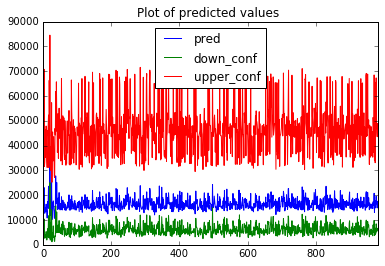

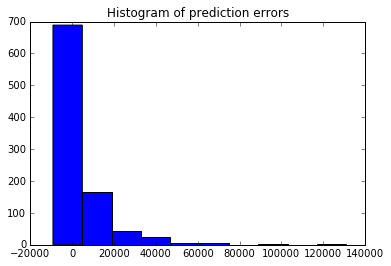

In [57]:
DR.plot()
plt.title("Plot of predicted values ")
plt.figure()
errors=[a-b for a,b in zip(list(y_test),list(DC['pred']))]
plt.title("Histogram of prediction errors")
plt.hist(errors)
print("Mean absolute error:")
print(mean_absolute_error(list(y_test), list(DC['pred'])))
print("Marginal log-likelihood")
print(rf.score(X_test_new, y_test.values))
print("MSE of prediction:")
print(mean_squared_error(list(y_test), list(DC['pred'])))
print("Average relative accuracy:")
print(100-np.average(abs((list(DC['pred'])-y_test.values)/y_test.values)))
D.to_csv("/Users/annachystiakova/python_project/tangramm/tangramm/prediction_results.csv")

#### Conclusion
The sample of input data for training, which contains 42 units was analysed to design the model for prediction of test sample. It was defined that the features contain the number of significant and insignificant features, which can be identified using the combination of models. These models assess the dependencies between the features and outcome classes. The complex assessment of feature's influence, stability gives the weighted assessment for the features which is defined as the ranks of the features. So, the features are sorted by the rank and the significant are choosen. This step allowed to eliminate the noise from the features sample, used for training. The second step is to arrange the the features into the groups because we are still faced with the curse of dimensionality and try to avoid the multicollinearity. The hierarchical aggregation clustering was used for this. The number of clusters was coosen using Silhouette method. The 70 groups were designed and means(centers) of these groups used to fit the model.
According to the big scatter of data the "dotted accurate" forecast doesn't have sense in fact, so the interval forecast for non-normal distributed outcome is required. The Quantile Regression Forests model was used and fitted. Using this model the 90% confidence inteval was calculated for the prediction. According to the results 83.5% of real values are in the confidence interval, however the Mean absolute error is still big (7566).
I think if the train sample contains more units, at least 10 times the results of prediction will be definitely better. It will be possible to perform cross validation inside the train data.